In [2]:
import csv
import math
import ast
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from tqdm import tqdm

map_matrix_cart = []
map_matrix_polar = []

/home/eliot/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:
def read_eos_geometry(filename):
    row_x = 1
    row_y = 2
    row_z = 3
    
    #Read CSV
    df = pd.read_csv(filename)
    
    matrix = df.to_numpy()
    
    r_cylindrical = np.sqrt(matrix[:, row_x]**2 + matrix[:, row_z]**2)
    
    theta_cylindrical = np.arctan2(matrix[:, row_y], matrix[:, row_x]) * -180 / np.pi + 180
    theta_degrees = theta_cylindrical * 180 / math.pi
    
    df['R Length'] = r_cylindrical
    df['Theta'] = theta_cylindrical
    df['Height'] = matrix[:, row_z]
    
    height = matrix[:, row_z]
    return df
    
read_eos_geometry('metaData.csv')

,PMT ID,X Position,Y Position,Z Position,R Length,Theta,Height
0,0,-681.965000,-390.919000,-991.096000,1203.057581,330.177612,-991.096000
1,1,-736.027000,-138.561000,-1116.930000,1337.635365,349.338543,-1116.930000
2,2,-697.283000,131.268000,-1026.750000,1241.136231,10.661517,-1026.750000
3,3,-681.965000,390.919000,-991.096000,1203.057581,29.822388,-991.096000
4,4,-477.826000,-546.650000,-1126.764000,1223.893295,311.156661,-1126.764000
...,...,...,...,...,...,...,...
236,236,285.518401,814.309562,1066.501827,1104.059285,109.322011,1066.501827
237,237,582.819656,-658.263043,1058.728087,1208.546198,228.478636,1058.728087
238,238,607.948537,-333.708127,1137.230690,1289.532887,208.762758,1137.230690
239,239,616.402121,0.000000,1163.639680,1316.817709,180.000000,1163.639680


In [4]:
def read_annie_geometry(filename):
        
    # Step 1: Read the CSV file
    df = pd.read_csv('FullTankPMTGeometry.csv')
    
    # Step 2: Drop the first 4 rows and the last row
    df = df.iloc[4:-1]  # .iloc to slice, starting from the 5th row to the second-to-last row
    
    # Step 3: Select the first, fifth, sixth, and seventh columns
    selected_columns = df.iloc[:, [0, 4, 5, 6]]  # 0, 4, 5, and 6 are the indices for the first, fifth, sixth, and seventh columns
    
    # Step 4: Convert the selected columns to numeric values
    selected_columns = selected_columns.apply(pd.to_numeric, errors='coerce')  # Converts columns to numeric types
    selected_columns.columns = ['PMT ID', 'X Position', 'Y Position', 'Z Position']

    annie_geo = selected_columns
    # Step 5: Convert the selected columns to a matrix (numpy array)
    matrix = selected_columns.to_numpy()
    
    # Step 6: Add .1446 to the third column (index 2) and -1.681 to the fourth column (index 3)
    matrix[:, 2] += 0.1446  # Add .1446 to the third column (index 2)
    matrix[:, 3] += -1.681  # Add -1.681 to the fourth column (index 3)
    
    # Step 7: Calculate cylindrical coordinates
    # r = sqrt(x^2 + z^2)
    r_cylindrical = np.sqrt(matrix[:, 1]**2 + matrix[:, 3]**2)  # matrix[:, 1] is x, matrix[:, 3] is z

    # theta = atan2(z, x) (angle in the xy-plane)
    theta_cylindrical = np.arctan2(matrix[:, 3], matrix[:, 1])  # matrix[:, 3] is z, matrix[:, 1] is x
    
    # y = height (directly taken from the third column)
    height = matrix[:, 2]  # matrix[:, 2] is y, which is the height

    annie_geo['R Length'] = r_cylindrical
    annie_geo['Theta'] = theta_cylindrical
    annie_geo['Height'] = height

    return annie_geo

read_annie_geometry('FullTankPMTGeometry.csv')

,PMT ID,X Position,Y Position,Z Position,R Length,Theta,Height
4,333,-0.247685,-1.693962,1.603793,0.259439,-2.839422,-1.549362
5,334,-0.775424,-1.693962,1.508324,0.794418,-2.922482,-1.549362
6,335,-0.445549,-1.693962,1.802155,0.461728,2.876090,-1.549362
7,336,-0.577560,-1.685249,1.309961,0.686473,-2.570562,-1.540649
8,337,0.191253,-1.693962,2.460463,0.802583,1.330185,-1.549362
...,...,...,...,...,...,...,...
130,459,0.920851,0.864528,2.244969,1.079827,0.549519,1.009128
131,460,-0.266620,0.862612,2.728097,1.080509,1.820126,1.007212
132,461,0.549892,0.863099,2.608747,1.078469,1.035748,1.007699
133,462,0.264898,0.010389,2.724132,1.076242,1.322108,0.154989


In [5]:
def id_to_geo(id, geometry):
    id_list = geometry.iloc[:,0].to_numpy()
    for i in range(0, len(id_list)):
        if id_list[i] == id:
            return geometry.iloc[i,:].to_numpy()
        else:
            continue
annie_geo = read_annie_geometry("FullTankPMTGeometry.csv")

geo = id_to_geo(333, annie_geo)
print(geo)

[ 3.33000000e+02 -2.47684600e-01 -1.69396230e+00  1.60379270e+00
  2.59439065e-01 -2.83942202e+00 -1.54936230e+00]


In [6]:
def read_data(filename):
    #Load data
    df = pd.read_csv(filename)
    event_numbers = df.iloc[:,0]
    
    all_events = []
    #Loop by each row where row is event
    for i in range(0, len(event_numbers)):
        ncolumns = len(df.iloc[i,:])
        if(ncolumns > 4):
            print("WTF")
        Nhits = len(json.loads(df.iloc[i,1]))
        event = []
        #loop through the entries in a given column
        for j in range(0, Nhits-1):
            AHit = [json.loads(df.iloc[i,1])[j], json.loads(df.iloc[i,2])[j], json.loads(df.iloc[i,3])[j]]
            event.append(AHit)
        all_events.append(event)
    return all_events
    

In [7]:
def plot_hit(events, collab_name, geometry, output_name, axes):
    ax0, ax1, ax2 = axes
    #Sort hard-coded values by collaboration
    if collab_name.lower() == 'eos':
        max_height = 1000
        min_height = -750
        end_cap_min_x = -900
        end_cap_max_x = 900
        end_cap_min_y = end_cap_min_x
        end_cap_max_y = end_cap_max_x
        x_ind = 1
        y_ind = 2
        height_ind = 3
        theta_ind = 5
    elif collab_name.lower() == 'annie':
        max_height = 1.1
        min_height = -1.3
        end_cap_min_x = 0.5
        end_cap_max_x = 2.75
        end_cap_min_y = -1
        end_cap_max_y = 1
        x_ind = 3
        y_ind = 1
        height_ind = 6
        theta_ind = 5
    else:
        print("Unsupported Collaboration Name")
        return 0
        
    #Load meta data
    event_pos = id_to_geo(events[0], geometry)
    x_pos = event_pos[x_ind]
    y_pos = event_pos[y_ind]
    height = event_pos[height_ind]
    theta_cylindrical = event_pos[theta_ind]

    #Create the figure
    if height < max_height and height > min_height:
        #Plot the Barrel
        ax1.scatter(theta_cylindrical, height, c=events[1], vmin = 0, vmax = 1000, cmap='viridis', marker='o', label='PMT locations', s=300)
        ax1.set_title('Unfolded Cylindrical Barrel View')
        ax1.set_xlabel('Theta (radians) - Angle Around the Cylinder')
        ax1.set_ylabel('Height (y) - Vertical Position in Tank')
        
    #Plot the Top End Cap
    elif height > max_height:
        ax0.set_xlim(end_cap_min_x, end_cap_max_x)
        ax0.set_ylim(end_cap_min_y, end_cap_max_y)
        ax0.scatter(x_pos, y_pos, c=events[1], cmap='viridis', vmin = 0, vmax = 1000, marker='o', label='PMT locations', s=360)
        ax0.set_title('Top End Cap Heat Map')
        ax0.set_xlabel('X Position (mm)')
        ax0.set_ylabel('Y position (mm)')

    elif height < min_height:
        #Plot the Bottom End Cap
        ax2.set_xlim(end_cap_min_x, end_cap_max_x)
        ax2.set_ylim(end_cap_min_y, end_cap_max_y)
        ax2.scatter(x_pos, y_pos, c=events[1], cmap='viridis', vmin = 0, vmax = 1000, marker='o', label='PMT locations', s=200)
        ax2.set_title('Bottom End Cap Heat Map')
        ax2.set_xlabel('X Position (mm)')
        ax2.set_ylabel('Y position (mm)')

# TO DO:
#    Add Flipbook functionality
#         Loop through each event and paste the plots to some sort of pdf
#     Once we have ANNIE data, condense the plotting parts (we just need to be able to use the intensity arrays)

TypeError: 'NoneType' object is not subscriptable

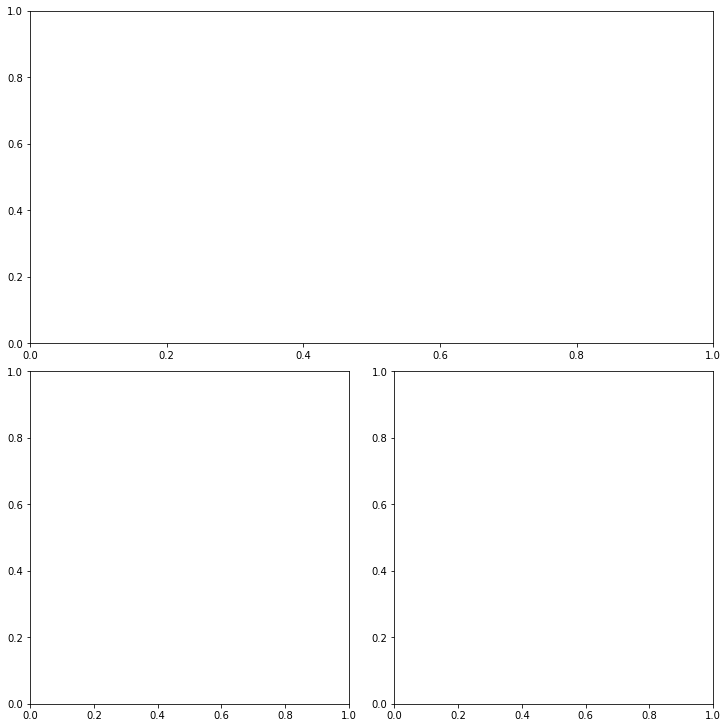

In [8]:
annie_data = read_data("annieLaser4692.csv")
annie_geo = read_annie_geometry("FullTankPMTGeometry.csv")

fig = plt.figure(figsize=(10,10), layout="constrained")
spec = fig.add_gridspec(2,2)

ax0 = fig.add_subplot(spec[1,0])
ax1 = fig.add_subplot(spec[0,:])
ax2 = fig.add_subplot(spec[1,1])

with PdfPages('test.pdf') as pdf:
    for i in range(0,100):
        ax0.clear()
        ax1.clear()
        ax2.clear()
        for j in range(0, len(annie_data[i])):
            plot_hit(annie_data[i][j], 'annie', annie_geo, 'sample', (ax0,ax1,ax2))
        pdf.savefig(fig)
    
            


100%|████████████████████████████████████████████████████████████████████████████| 100/100 [01:57<00:00,  1.17s/it]


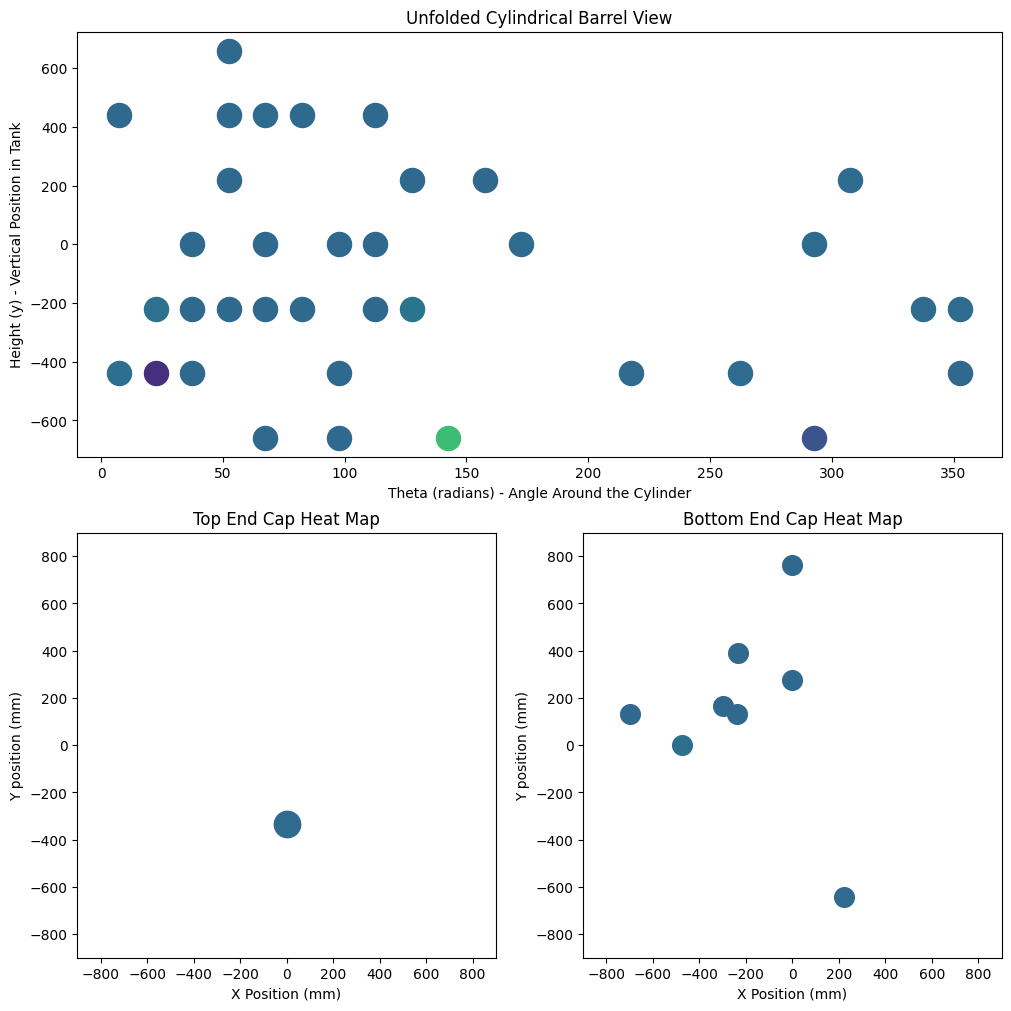

In [121]:
plt.ion()

eos_data = read_data("outputData.csv")
eos_geo = read_eos_geometry("eosMetaMap.csv")

fig = plt.figure(figsize=(10,10), layout="constrained")
spec = fig.add_gridspec(2,2)

ax0 = fig.add_subplot(spec[1,0])
ax1 = fig.add_subplot(spec[0,:])
ax2 = fig.add_subplot(spec[1,1])

with PdfPages('test_eos.pdf') as pdf:
    for i in tqdm(range(0,100)):
        ax0.clear()
        ax1.clear()
        ax2.clear()
        for j in range(0, len(eos_data[i])):
            plot_hit(eos_data[i][j], 'eos', eos_geo, 'sample', (ax0,ax1,ax2))
        pdf.savefig(fig)
        # with PdfPages( 'test.pdf') as pdf:
        #     pdf.savefig(fig)
            


In [4]:
def plot_tank(df, intensity, collab_name, output_name):
    with PdfPages(output_name + '.pdf') as pdf:
        for event in tqdm(intensity):
            #Create the subsets for top, bottom and barrels
            barrel_height = []
            barrel_theta = []
            barrel_intensity = []
            
            top_x = []
            top_y = []
            top_intensity = []
        
            bot_x = []
            bot_y = []
            bot_intensity = []
        
            #Clunky mess for Eos Stuff
            if collab_name.lower() == 'eos':
                #load all the necessary meta data
                x_pos = df['X Position']
                y_pos = df['Y Position']
                height = df['Z Position']
                theta_cylindrical = df['Theta']
            
                #Sort the data by height
                for i in range(0, len(height)):
                    if height[i] < 1000 and height[i] > - 750:
                        barrel_height.append(height[i])
                        barrel_theta.append(theta_cylindrical[i])
                        barrel_intensity.append(event[i])
                    elif height[i] > 1000:
                        top_x.append(x_pos[i])
                        top_y.append(y_pos[i])
                        top_intensity.append(event[i])
                    elif height[i] < -750:
                        bot_x.append(x_pos[i])
                        bot_y.append(y_pos[i])
                        bot_intensity.append(event[i])
        
                 #Create the figure
                fig = plt.figure(figsize=(10,10), layout="constrained")
                spec = fig.add_gridspec(2,2)
            
                 #Plot the Barrel
                ax1 = fig.add_subplot(spec[0,:])
                plt.scatter(barrel_theta, barrel_height, c=barrel_intensity, cmap='viridis', marker='o', label='PMT locations', s=300)
                plt.title('Unfolded Cylindrical Barrel View')
                plt.xlabel('Theta (radians) - Angle Around the Cylinder')
                plt.ylabel('Height (y) - Vertical Position in Tank')
                
                #Plot the Top End Cap
                ax0 = fig.add_subplot(spec[1,0])
                plt.xlim(-900,900)
                plt.ylim(-900,900)
                plt.scatter(top_x, top_y, c=top_intensity, cmap='viridis', marker='o', label='PMT locations', s=360)
                plt.title('Top End Cap Heat Map')
                plt.xlabel('X Position (mm)')
                plt.ylabel('Y position (mm)')
                
                #Plot the Bottom End Cap
                ax2 = fig.add_subplot(spec[1,1])
                plt.scatter(bot_x, bot_y, c=bot_intensity, cmap='viridis', marker='o', label='PMT locations', s=200)
                plt.title('Bottom End Cap Heat Map')
                plt.xlabel('X Position (mm)')
                plt.ylabel('Y position (mm)')
               
                # Show the plot
                pdf.savefig(fig)
                #plt.show()
                plt.close()
        
            #Clunky mess for Annie Stuff
            elif collab_name.lower() == 'annie':
                #load all the necessary meta data
                beam_pos = df["Z Position"].to_numpy()
                perp_pos = df["X Position"].to_numpy()
                height = df["Height"].to_numpy()
                theta_cylindrical = df["Theta"].to_numpy()
        
                #Sort the data by height
                for i in range(0, len(height)):
                    if height[i] < 1.1 and height[i] > -1.3:
                        barrel_height.append(height[i])
                        barrel_theta.append(theta_cylindrical[i])
                        #barrel_intensity.append(intensity[i])
                    elif height[i] > 1.2:
                        top_x.append(beam_pos[i])
                        top_y.append(perp_pos[i])
                       # top_intensity.append(intensity[i])
                    elif height[i] < -1.3:
                        bot_x.append(beam_pos[i])
                        bot_y.append(perp_pos[i])
                       # bot_intensity.append(intensity[i])
        
                #Create the figure
                fig = plt.figure(figsize=(10,10), layout="constrained")
                spec = fig.add_gridspec(2,2)
        
                #Plot the Barrel
                ax1 = fig.add_subplot(spec[0,:])
                plt.scatter(barrel_theta, barrel_height, cmap='viridis', marker='o', label='PMT locations', s=300)
                plt.title('Unfolded Cylindrical Barrel View')
                plt.xlabel('Theta (radians) - Angle Around the Cylinder')
                plt.ylabel('Height (y) - Vertical Position in Tank')
                
                #Plot the Top End Cap
                ax0 = fig.add_subplot(spec[1,0])
                plt.scatter(top_x, top_y, cmap='viridis', marker='o', label='PMT locations', s=360)
                plt.title('Top End Cap Heat Map')
                plt.xlabel('Beam Position (m)')
                plt.ylabel('Perpendicular position (m)')
                
                #Plot the Bottom End Cap
                ax2 = fig.add_subplot(spec[1,1])
                plt.scatter(bot_x, bot_y, cmap='viridis', marker='o', label='PMT locations', s=200)
                plt.title('Bottom End Cap Heat Map')
                plt.xlabel('Beam Position (m)')
                plt.ylabel('Perpendicular position (m)')
               
                # Show the plot
                plt.show()
                
            else:
                print("Unsupported Collaboration Name")
                return 0

# TO DO:
#    Add Flipbook functionality
#         Loop through each event and paste the plots to some sort of pdf
#     Once we have ANNIE data, condense the plotting parts (we just need to be able to use the intensity arrays)

In [18]:
#'Make Class' Loop
eos_data = read_data("outputData.csv")
print(eos_data[0])
# print(eos_data)
annie_data = read_data("annieLaser4692.csv")
print()
print(annie_data[0])
# print(annie_data)
#print(annie_data[0])

[[3, 338.07612105263155, 2.5537109375], [6, 335.60793333333334, 2.9003906250000533], [17, 333.1215235955056, 3.5009765624998934], [20, 336.6860117647059, 2.1972656250000533], [22, 354.46991329479766, 2.529296875], [23, 335.16855510204084, 2.1972656249999467], [27, 335.0774666666666, 2.9443359375000533], [52, 347.8486, 2.4121093750000533], [53, 334.9545483870968, 2.4902343749999467], [54, 337.1759333333333, 2.1630859375000533], [59, 337.7192857142858, 1.6162109374999467], [61, 336.2063, 1.9091796875], [66, 337.50314444444444, 1.2207031249999467], [71, 339.14548947368417, 2.3632812500000533], [72, 337.38900526315786, 2.1191406250001066], [73, 337.6277888888889, 4.794921875], [74, 337.9063290322581, 4.140624999999893], [75, 337.07675454545455, 3.6279296874999467], [80, 337.31498275862066, 2.3437500000001066], [81, 337.81508767123285, 2.7246093749998934], [83, 338.15002093023253, 1.8115234374998934], [85, 339.5380777777778, 1.7773437499998934], [86, 336.564393006993, 4.912109374999893], [8

In [11]:
#Proof of concept: Plotting Eos
eos_geometry = read_eos_geometry('metaData.csv')
intensities = read_data('outputData.csv', 'Time')
plot_tank(eos_geometry, intensities, 'eos', "Eos_Time")

intensities_2 = read_data('outputData.csv', 'Charge')
plot_tank(eos_geometry, intensities_2, 'eos', "Eos_Charge")

NameError: name 'read_eos_geometry' is not defined

  0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_10287/824452740.py:101: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(barrel_theta, barrel_height, cmap='viridis', marker='o', label='PMT locations', s=300)
/tmp/ipykernel_10287/824452740.py:108: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(top_x, top_y, cmap='viridis', marker='o', label='PMT locations', s=360)
/tmp/ipykernel_10287/824452740.py:115: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(bot_x, bot_y, cmap='viridis', marker='o', label='PMT locations', s=200)


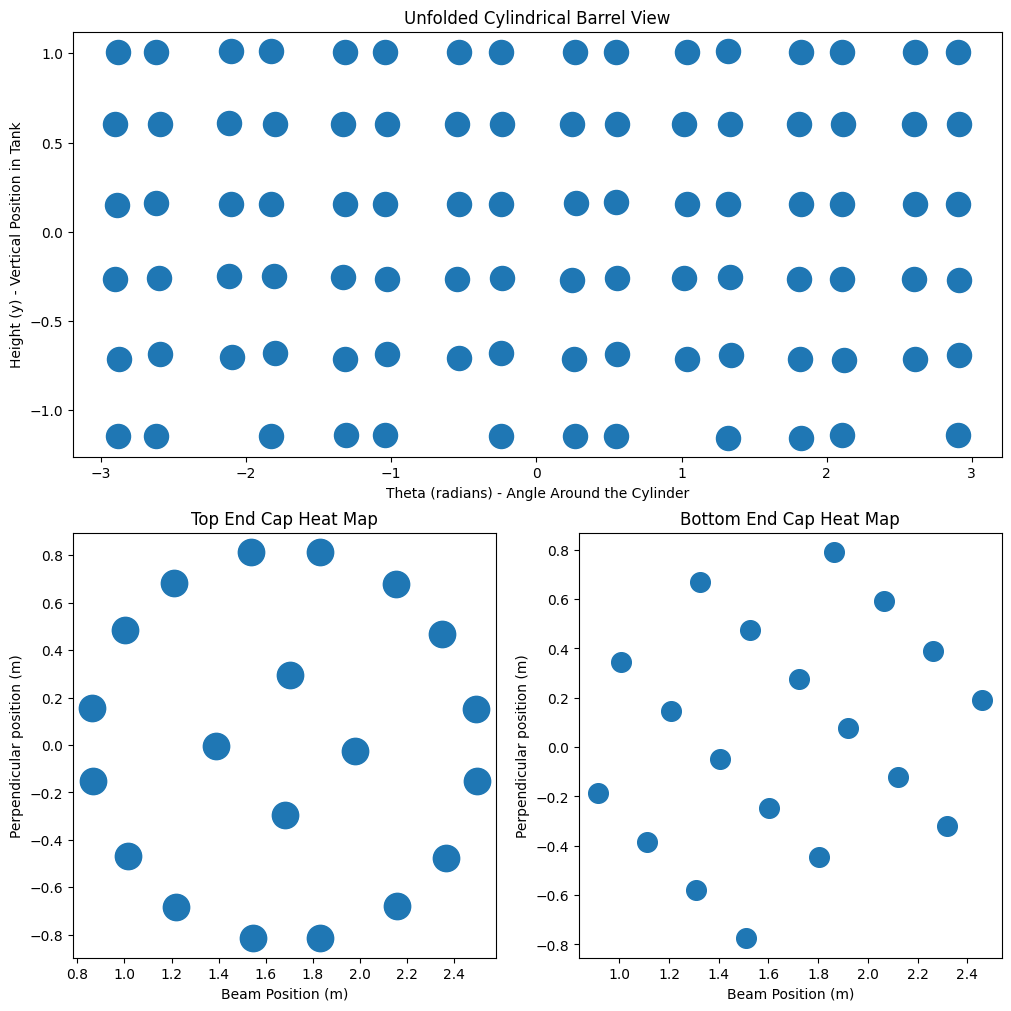

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.04s/it]
/tmp/ipykernel_10287/824452740.py:2: MatplotlibDeprecationWarning: Keeping empty pdf files is deprecated since 3.8 and support will be removed two minor releases later.
  with PdfPages('event_display.pdf') as pdf:


In [10]:
#Proof of concept: Plotting Annie
annie_geometry = read_annie_geometry('FullTankPMTGeometry.csv')
plot_tank(annie_geometry, [[]], 'annie')

# TO DO:
# Get ANNIE Data from Eli
# Play with that data to see if it works as expected

In [55]:
#Function to find info for a given PMT
def find_pmt_info(map_matrix, pmt_id):
    return(map_matrix[pmt_id])

In [57]:
"""
Loop through each event, load into a form
Module that takes that form and displays it
Add functionality: range, cuts, etc. 
"""

'\nLoop through each event, load into a form\nModule that takes that form and displays it\nAdd functionality: range, cuts, etc. \n'

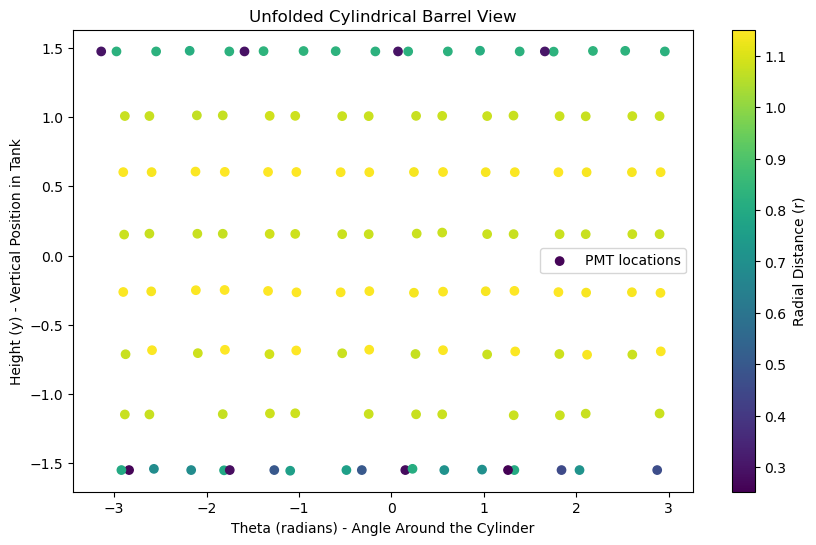

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Read the CSV file
df = pd.read_csv('FullTankPMTGeometry.csv')


# Step 2: Drop the first 4 rows and the last row
df = df.iloc[4:-1]  # .iloc to slice, starting from the 5th row to the second-to-last row

# Step 3: Select the first, fifth, sixth, and seventh columns
selected_columns = df.iloc[:, [0, 4, 5, 6]]  # 0, 4, 5, and 6 are the indices for the first, fifth, sixth, and seventh columns

# Step 4: Convert the selected columns to numeric values
selected_columns = selected_columns.apply(pd.to_numeric, errors='coerce')  # Converts columns to numeric types

# Step 5: Convert the selected columns to a matrix (numpy array)
matrix = selected_columns.to_numpy()

# Step 6: Add .1446 to the third column (index 2) and -1.681 to the fourth column (index 3)
matrix[:, 2] += 0.1446  # Add .1446 to the third column (index 2)
matrix[:, 3] += -1.681  # Add -1.681 to the fourth column (index 3)

# Step 7: Calculate cylindrical coordinates
# r = sqrt(x^2 + z^2)
r_cylindrical = np.sqrt(matrix[:, 1]**2 + matrix[:, 3]**2)  # matrix[:, 1] is x, matrix[:, 3] is z

# theta = atan2(z, x) (angle in the xy-plane)
theta_cylindrical = np.arctan2(matrix[:, 3], matrix[:, 1])  # matrix[:, 3] is z, matrix[:, 1] is x

# y = height (directly taken from the third column)
height = matrix[:, 2]  # matrix[:, 2] is y, which is the height

# Step 8: Plotting the unfolded cylindrical barrel

# Set up the figure and axis
plt.figure(figsize=(10, 6))

# Plot the PMT locations on the unfolded cylindrical barrel
# We use theta as the x-axis (representing the angle around the cylinder) and r as the y-axis (radial distance from the center)
plt.scatter(theta_cylindrical, height, c=r_cylindrical, cmap='viridis', marker='o', label='PMT locations')

# Add labels and title
plt.title('Unfolded Cylindrical Barrel View')
plt.xlabel('Theta (radians) - Angle Around the Cylinder')
plt.ylabel('Height (y) - Vertical Position in Tank')
plt.colorbar(label='Radial Distance (r)')
plt.legend()

# Show the plot
plt.show()
